In [1]:
#db stuff
from sqlalchemy import (create_engine, inspect, desc, Table, Column, Integer, String, DateTime, MetaData)
from sqlalchemy.sql import select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import json

#time handlers
import time
from datetime import (datetime,timedelta)

#numerics
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import dates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#specialiced classes from ankit
import data
from queues import *

#machine learning
from sklearn import preprocessing
from sklearn.decomposition import PCA

queues module loaded
data module loaded


# Plot Settings

In [2]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'System San Francisco Display Regular', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'System San Francisco Display Regular', 'size':'14'}
font_path = "/Library/Fonts/System San Francisco Display Regular.ttf"
font_path_bf = "/Library/Fonts/System San Francisco Display Bold.ttf"
font_prop_title = font_manager.FontProperties(fname=font_path_bf, size=30)
font_prop_axis = font_manager.FontProperties(fname=font_path, size=26)
font_prop_legend = font_manager.FontProperties(fname=font_path, size=20)

#date formatter:
hfmt = dates.DateFormatter('%Y-%m-%d')

# Useful functions

In [3]:
def string_to_list(string):
    split=string.replace('[','').replace(']','').replace('\'','').split(',')
    split=[x.strip() for x in split]
    return split

def merge_alloc_dicts(dict1,dict2):
    result=dict1.copy()
    
    for key in dict2:
        if key in dict1:
            tmpval=dict1[key]+dict2[key]
            if tmpval==0:
                del result[key]
            else:
                result[key]=tmpval
    return result

# SQLAlchemy Setup

In [4]:
#connect to db and return a cursor:
with open('/Users/tkurth/Dropbox/Documents/NERSC/General/mysql_staffdb_creds.json') as mysql_creds:
        conn_config = json.load(mysql_creds)

hostname=conn_config['host']
databasename=conn_config['database']
username=conn_config['user']
password=conn_config['password']
portnumber=conn_config['port']

#create engine
eng = create_engine('mysql://'+username+':'+password+'@'+hostname+':'+portnumber+'/'+databasename)
#meta=MetaData()
#meta.reflect(bind=eng)
base = declarative_base()
base.metadata.bind = eng
base.metadata.reflect(bind=eng)

#session
session = sessionmaker(bind=eng)
sess = session()

#get summary table:
summary=base.metadata.tables['summary']

# Get the Data

In [7]:
"""This is basically main.py"""
# Global params
directory = "/Users/tkurth/Dropbox/Documents/NERSC/JobWaitPredict/ankit/qpredict/data/"
    
with open('/Users/tkurth/Dropbox/Documents/NERSC/General/mysql_staffdb_creds.json') as mysql_creds:
    conn_config = json.load(mysql_creds)

hostname=conn_config['host']
databasename=conn_config['database']
username=conn_config['user']
password=conn_config['password']
portnumber=conn_config['port']

tstart = "1458591001"

for machine in ['cori']:
    debug = DebugQueue(machine)
    regular = RegQueue(machine)
    shared = SharedQueue(machine)
    
    queue = {} # Return object for queue data
    completed = {} # Return object for completed job data

    try:
        with open("snapshots_"+machine+".txt") as f:
            timestamps = f.read().splitlines()
    except IOError:
        print "Error opening timestamps file"

    # Get current queue data
    queue = data.loadQueuedJobData(machine,directory,timestamps)
    debug.queuedJobs  = {k:v for k,v in queue.items() if v.partition == 'debug'} #filter(lambda x: x.partition == 'debug', coriJobList)
    regular.queuedJobs = {k:v for k,v in queue.items() if (v.partition == 'regular') | (v.partition == 'regularx')} 
    shared.queuedJobs = {k:v for k,v in queue.items() if v.partition == 'shared'} #filter(lambda x: x.partition == 'shared', coriJobList) 

    # Get completed jobs data
    completed = data.loadCompletedJobData(machine,tstart,databasename,username,password,hostname,portnumber)

# Pack into dataframe for quick data transformations

In [8]:
# I like chinese bears, so I pack the data into a pandas dataframe
queuedf=pd.DataFrame([x.to_dict() for x in queue.values()])
#rename columns with class labels to apply one-hot later
queuedf.rename(columns={'partition':'partition_tag','qos':'qos_tag'},inplace=True)
queuedf.sort(['jobId'],inplace=True)

#completed
compdf=pd.DataFrame([x.to_dict() for x in completed.values()])
del compdf['machine']
del compdf['partition']
del compdf['qos']
del compdf['reqNodes']
del compdf['reqWalltime']
del compdf['obsWalltime']
compdf['obsWaitTime']=compdf['obsWaitTime'].astype(float)
#observed waittime is label
compdf.rename(columns={'obsWaitTime':'obsWaitTime_label'},inplace=True)
compdf.sort(['jobId'],inplace=True)

In [9]:
#merge the frames on jobid:
alldf=pd.merge(compdf,queuedf,how='inner',on='jobId')
del alldf['machine']

#only take values where partition is specified
alldf.dropna(axis=0,how='any',inplace=True)

alldf.reset_index(drop=True,inplace=True)

# Plot Distribution of Wait times

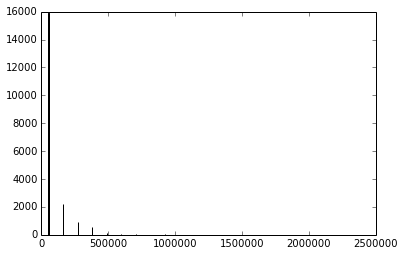

In [10]:
Y,X=np.histogram(list(alldf[alldf.qos_tag!='scavenger']['obsWaitTime_label']),bins=20)
X=[0.5*(X[i]+X[i+1]) for i in range(len(X)-1)]
plt.bar(X,Y,width=200)
plt.show()

In [18]:
#show maximum wait times:
alldf.sort(['obsWaitTime_label'],ascending=False)[alldf.qos_tag!='scavenger']

/Library/Python/2.7/site-packages/pandas-0.16.0-py2.7-macosx-10.10-intel.egg/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,jobId,obsWaitTime_label,age,fairshare,partition_tag,priority,qos_tag,qos_int,rank_p,reqNodes,reqWalltime
5,1235954,2177071,7,282,regular,65084,normal,64800,1549,2,129600
4,1235953,1920568,6518,303,regular,28420,normal,21600,113,2,129600
6,1259900,1794275,29899,0,regular,84619,low,54720,1,8,129600
7,1264559,1646071,4012,0,regular,25611,normal,21600,402,64,86400
14,1270164,1486813,7395,0,regular,28995,normal,21600,84,96,129600
17,1288106,1472253,7,0,regular,64802,normal,64800,4899,80,9000
27,1292562,1438027,0,188,regular,64987,normal,64800,2711,1,43200
16,1288105,1321589,1972,0,regular,23571,normal,21600,880,80,9000
25,1292519,1303295,2,256,regular,21857,normal,21600,2808,1,21600
29,1293124,1300862,2,256,regular,21857,normal,21600,2807,1,21600


# Do One-Hot Encoding and PCA 

In [11]:
#generate class labels for one-hot encoding
partitions=list(set(alldf['partition_tag']))
qosclasses=list(set(alldf['qos_tag']))
hotdf=alldf.copy()
hotdf['partition_tag']=alldf.apply(lambda x: partitions.index(x['partition_tag']),axis=1)
hotdf['qos_tag']=hotdf.apply(lambda x: qosclasses.index(x['qos_tag']),axis=1)

#all columns with "tag" suffixes get one-hot encoded:
onehotcolumns=[x for x in hotdf.columns[2:] if 'tag' in x]
for feature in onehotcolumns:
    #what is the number of categories:
    num_cat=np.max(hotdf[feature])+1
    #create dataframe to fill
    fname=feature.split('tag')[0]
    hotcols=[fname+str(c) for c in range(num_cat)]
    tmpcols=['jobId']+hotcols
    tmpdf=pd.DataFrame(columns=tmpcols)
    tmpdf[['jobId']]=hotdf[['jobId']].copy()
    for c in hotcols:
        tmpdf[hotcols]=0.
    #join back the frames
    hotdf=pd.merge(hotdf,tmpdf,how='inner',on='jobId').copy()
    
    #set the hotcols to the correct values
    for i in range(num_cat):
        hotdf.loc[hotdf[feature]==i,fname+str(i)]=1.

#delete tag columns
del hotdf['qos_tag']
del hotdf['partition_tag']

## Perform PCA

In [12]:
#perform preprocessing to stabilize PCA
X=hotdf.as_matrix(columns=hotdf.columns[2:])
X=preprocessing.scale(X,with_mean=True,with_std=True,axis=0)
Y=np.asarray(hotdf.as_matrix(columns=['obsWaitTime_label']),dtype=float)
Y=preprocessing.scale(Y,with_mean=True,with_std=True,axis=0)

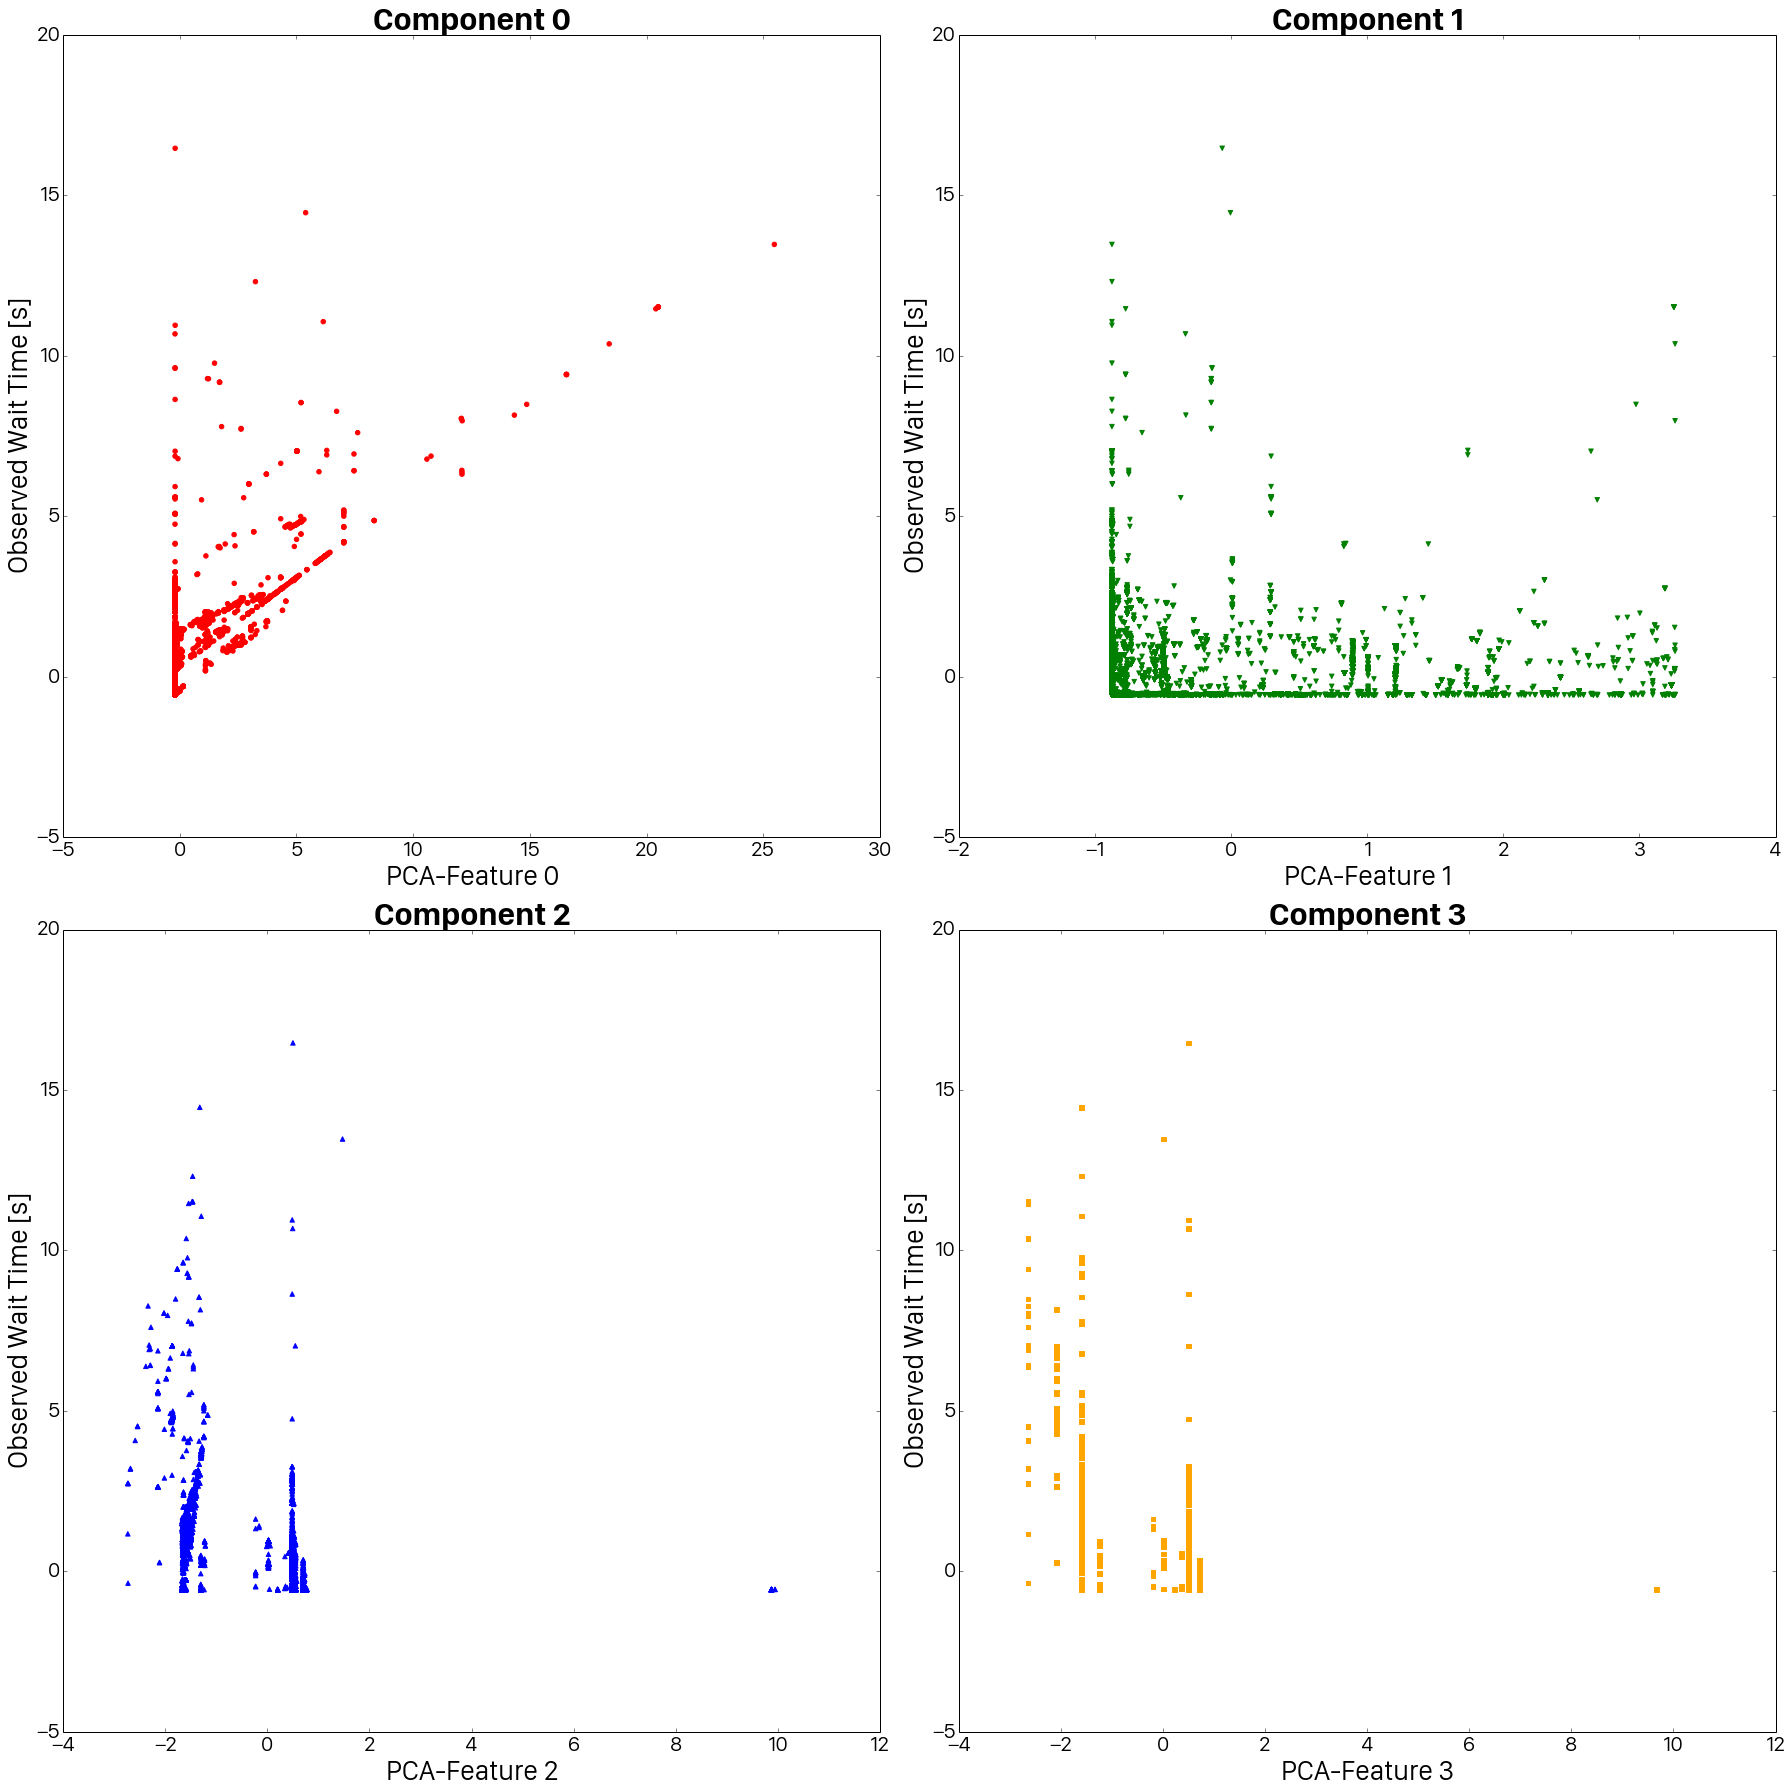

In [16]:
#perform PCA and plot:
num_comps=4
num_cols=2
pca = PCA(n_components=num_comps)
pca.fit_transform(X)

#plot
fig, axvec= plt.subplots(figsize=(25, 25), nrows=int(np.ceil(num_comps/num_cols)), ncols=num_cols)
colors=['red','green','blue','orange']
markers=['o','v','^','s']

for idx in range(num_comps):
    colid=int(idx%num_cols)
    rowid=int(idx-colid)/num_cols
    ax=axvec[rowid,colid]
    
    ax.set_title('Component '+str(idx),fontproperties=font_prop_title)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop_axis)
        label.set_fontsize(20)
    ax.set_xlabel('PCA-Feature '+str(idx),fontproperties=font_prop_axis)
    ax.set_ylabel('Observed Wait Time [s]',fontproperties=font_prop_axis)
    ax=axvec[rowid,colid]
    ax.scatter(X[:,idx], np.reshape(Y,Y.shape[0]), color=colors[idx], marker=markers[idx])

plt.tight_layout()
plt.show()

# Store DF as CSV

In [ ]:
#split the sample in training, validation and testing
train_fraction=0.6
validation_fraction=0.2
test_fraction=0.2
numrows=hotdf.shape[0]
rows=np.arange(numrows)
np.random.shuffle(rows)
shuffledf=hotdf[hotdf.columns[1:]].iloc[rows].reset_index(drop=True)

#training set
train_stop=int(np.floor(train_fraction*numrows))
shuffledf[:train_stop].to_csv('cori_data_train.csv',header=True)
#validation set
validation_stop=int(np.floor(validation_fraction*numrows))+train_stop
shuffledf[train_stop:validation_stop].to_csv('cori_data_validate.csv',header=True)
#test set:
shuffledf[validation_stop:].to_csv('cori_data_test.csv',header=True)